In [1]:
# reload magics
%load_ext autoreload
%autoreload 2

## IMPORTS

In [2]:
import colorcet as cc
import logging
import matplotlib.colors as mc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.axes import Axes

from hdbscan import all_points_membership_vectors, HDBSCAN
from umap import UMAP

from copy import deepcopy, copy

from upsetplot import from_memberships, plot, UpSet, from_indicators

from typing import Dict, List, Tuple, Optional

palette = cc.glasbey_hv

# create a palette dictionary that has the same keys as the original palette
palette_dict = {i: mc.to_hex(palette[i]) for i in range(len(palette))} # type: ignore

# add an entry for -1
palette_dict[-1] = '#ffffff'

# set default colour for seaborn heatmaps
sns.set_theme(style = "whitegrid", rc={'figure.figsize':(8,8)}, palette='viridis')

# make a matplotlib cmap from limegreen to white
from matplotlib.colors import LinearSegmentedColormap

cmap = LinearSegmentedColormap.from_list("limegreen-white", 
                                         ["white", "limegreen"])



FONTSIZE = 24

In [3]:
# heatmap parms
heatmap_parms = {
                'cbar': False,
                'square': False,
                'linewidths': 0.5,
                'linecolor': 'black',
                'center': 0.0,
                'vmin': -1,
                'vmax': 1,
                # 'annot': False,
                'fmt': '.2f',
}

# from the data dictionary
site_name_dict = {
                  1: 'LDN',
                  2: 'MTL',
                  3: 'SAN',
                  4: 'RIO',
                  5: 'LUS',
}
# from the data dictionary
site_fullname_dict = {
                  'LDN': "London",
                  'MTL': "Montreal",
                  'SAN': "San Diego",
                  'RIO': "Rio de Janeiro",
                  'LUS': "Lusaka",
}

# assign consistent styles
site_style_dict = {
              1: 'o',
              2: 'D',
              3: 'P',
              4: 'X',
              5: 's',
}

In [4]:
figdir    = "./OUTPUT/lc-pos-figures"
reportdir = "../lc2-report"
data_dir  = "../lc-project-data"

## FUNCTIONS

In [5]:
#===============================================================================
def compare_two_clusters(df, a, b):
#===============================================================================
# a function to compare two clusters - returns the concatenated cluster data for further analysis

    subset_a = df.query(f"cluster == {a}")
    subset_b = df.query(f"cluster == {b}")

    index_a = subset_a.index
    index_b = subset_b.index

    df_a = df.loc[index_a]
    df_b = df.loc[index_b]

    # concatenate
    df_ab = pd.concat([df_a, df_b])

    # cast cluster to int
    df_ab["cluster"] = df_ab["cluster"].astype(int)

    return df_ab


In [6]:
#===============================================================================
def make_centroids(e, lbls):
#===============================================================================

    # assume that lbls is a pandas series
    if isinstance(lbls, pd.Series):
        lbls = lbls.values
    


    # get the centroids of the umap coordinates by cluster
    centroids = pd.DataFrame(e, 
                                columns = ["x", "y"]).assign(cluster = lbls).groupby("cluster").mean()
    return centroids


#===============================================================================
def make_plot_df(embeddings, clusterer, index, sites):
#===============================================================================

    d = pd.DataFrame(embeddings, columns = ["x", "y"], index = index)
    d["Cluster"]             = clusterer.labels_
    d["Cluster Confidence"]  = clusterer.probabilities_


    try:
        d["Most Likely Cluster"] = np.argmax(all_points_membership_vectors(clusterer), axis = 1)
    except (KeyError, AttributeError):
        d["Most Likely Cluster"] = clusterer.labels_


    # EXPT

    d["Site"]                = sites


    return d



In [7]:
#===============================================================================
def plot_clusters(
                    df: pd.DataFrame, 
                    site_name_dict: dict,
                    centroids: Optional[bool] = False, 
                    title: Optional[str] = None,
                      most_likely: bool = False,
                      size_by_prob: bool = False,
                      ax: Optional[Axes] = None,
                      FONTSIZE: int = 24,
                      ):
#===============================================================================

    # plot the embeddings
    # fig, ax = plt.subplots(figsize=(10, 10))

    if ax == None:
        fig, ax = plt.subplots(figsize=(10, 10))
    else:
        fig = None
        ax = ax
        pass


    if most_likely:
        hue = "Most Likely Cluster"
    else:
        hue = "Cluster"

    if size_by_prob:
        size = "Cluster Confidence"
    else:
        size = None

    sns.scatterplot(data = df, 
                    x = "x",
                    y = "y",
                    s = 150,
                    edgecolor = 'black', 
                    hue       = hue,
                    linewidth = 0.5, 
                    palette   = palette_dict,
                    style     = "Site",
                    style_order = site_name_dict.values(),
                    markers = ['o','D', 'P', 'X', 's'],
                    size      = size,
                    # size      = "Cluster Confidence",
                    ax = ax
                        )

    if centroids is not None:
        # plot centroids
        if centroids == True:
            centroids = make_centroids(df[["x", "y"]].values, df["Cluster"])
            plot_centroids(centroids, ax, palette_dict = None)

    # set title
    if title:
        plt.title(title)

    # place the legend outside to the right of the plot
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    # turn off axis labels and ticks
    if ax == None:
        plt.xticks([]); plt.yticks([]);
        plt.xlabel(""); plt.ylabel("");

        # make labels larger
        plt.tick_params(axis='both', which='major', labelsize=16)

        # make the legend larger
        plt.setp(ax.get_legend().get_texts(), fontsize='24') # for legend text
        plt.setp(ax.get_legend().get_title(), fontsize='24') # for legend title

    # turn off x and y axis labels
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    # turn off grid
    ax.grid(False)
    
    # axis labels
    ax.set_xlabel("Dimension 1", fontsize = FONTSIZE)
    ax.set_ylabel("Dimension 2", fontsize = FONTSIZE)


    # make the legend larger
    plt.setp(ax.get_legend().get_texts(), fontsize=FONTSIZE-2) # for legend text
    plt.setp(ax.get_legend().get_title(), fontsize=FONTSIZE-2) # for legend title


    # return fig, ax

#===============================================================================
def plot_centroids(centroids, 
                   ax, 
                   alpha = 1.0, 
                   palette_dict = None, 
                   fontsize = 24,
                   show_edge = False,
                   ):
#===============================================================================
    # plot the centroids



    for i, centroid in centroids.iterrows():

        # don't plot the -1 cluster
        if i != -1:

            # plot in colour, if passed in
            if palette_dict is not None:
                ec = palette_dict[i]
            else:
                ec = 'w'

            if show_edge:
                ec = 'black'

            ax.annotate(
                        i,
                        (centroid.x, centroid.y), 
                        ha='center',
                        va='center',
                        bbox=dict(boxstyle="round,pad=0.3", 
                                    fc="k", 
                                    # ec="#ababab",
                                    ec = ec,
                                    # ec="w",
                                    # fc="white", 
                                    # ec="black",
                                    lw=2, 
                                    alpha=alpha,
                                    ),
                        fontsize = fontsize,
                        color = 'white',
                        # make font bold
                        fontweight = "bold",
                        )



In [8]:
#===============================================================================
def make_upset_data(df, 
                    ftrs, 
                    method = "mean", 
                    add_column = None,
                    keep_features = False):
#===============================================================================

    if method not in ["mean", "median"]:
        print(f"Method {method} not supported.")

    else:
        if method == "mean":
            new_df = df[ftrs] > df[ftrs].mean(axis = 0)
        # elif method == "median":
        else:
            new_df = df[ftrs] > df[ftrs].median(axis = 0)

    new_df = new_df[ftrs]
    new_df.rename(columns= {c: f">{c}" for c in ftrs}, inplace = True)

    df2 = pd.concat([df, new_df, add_column], axis = 1) # type: ignore
    # if keep_features == True:
    #     pass
    # else:
    #     df2 = df2.set_index(list(new_df.columns))

    return df2

In [9]:
#===============================================================================
def excursion_plot(d, 
                    method = "mean",
                    grouper = "cluster",
                    style: str = "binary",
                    # figsize = (6,64),
                    ax = None,
                    cmap = cc.cm.bjy,
                    top_n = None,
                    ):
#===============================================================================

    # TODO: colour map to match the cluster thumbnails
    # TODO: drop age, sex

    norm = None

    # qq.astype(int)
    if ax == None:
        fig, ax = plt.subplots()
    else:
        ax = ax


    # find all object columns and drop them
    d = d.select_dtypes(exclude = "object")

    # set the figsize to scale with the number of features
    figsize = (6, d.shape[1] / 5)

    # get the global median for each feature
    global_median = d.median()
    global_mean   = d.mean()

    globals = pd.concat([global_median, global_mean], axis = 1)
    globals.columns = ["Ensemble Median", "Ensemble Mean"]

    globals.drop(grouper, inplace = True)


    # per feature mean and median
    mm_mean   = d.groupby(grouper).mean().T
    mm_median = d.groupby(grouper).median().T

    # which version?
    if method == "mean":
        mm = mm_mean
        selector = "Ensemble Mean"
    elif method == "median":
        mm = mm_median
        selector = "Ensemble Median"
    else:
        print(f"Method {method} not supported.")
        

    if top_n is not None:
        mm = mm[:top_n]

    if style == "cont":
        # do the basic plot of means or medians
        # colourmap
        # cmap = cc.cm.bjy
        # fig, ax = plt.subplots(figsize=figsize)

        # heatmsp
        sns.heatmap(mm, 
                        cmap = cmap, 
                        ax   = ax, 
                        **heatmap_parms, 
                        norm = norm, 
                        annot = True,
                        annot_kws = {"fontsize": 8}
                        )

        plt.title(f"Excursion Plot: Feature {str.title(method)} by Cluster")
        plt.yticks(fontsize = 8);
        qq = None

    else:
        # mm is the mean or median per cluster per feature
        qq = pd.DataFrame(index = mm.index, columns = mm.columns)

        # for each cluster c in mm, 
        for c in mm.columns:
            # for each feature in this cluster, compare to the respective global mean
            for i, v in enumerate(mm[c].values):
                # is this cluster's mean or median greater than 
                # the global ensemble mean or median?
                # this will fill qq with true/false
                qq.loc[qq.index[i],c] = v >  globals.loc[qq.index[i], selector] # type: ignore

        # # qq.astype(int)
        # fig, ax = plt.subplots(figsize=figsize)

        sns.heatmap(qq.astype(int), 
                    # cmap = cc.bjy, 
                    cmap = cmap,
                    ax = ax, 
                    cbar = False, 
                    vmin = 0, 
                    linewidth = 0.5, 
                    square = False, 
                    linecolor = 'k'
                    )

        plt.yticks(fontsize = 8);
        plt.title(f"Excursion Plot: {str.title(grouper)} {str.title(method)} > {selector}")

    return globals, qq

In [10]:
#===============================================================================
def plot_cluster_by_site(src,
                         data,
                         labels,
                        site_name_dict: dict,

                         title: str,
                         tag: str,
                         ):
#===============================================================================

    # make a copy of the source data
    site_g = src.copy()

    # augment with cluster labels
    site_g.loc[data.index, "cluster"] = labels["Cluster"]

    # group and count
    cluster_by_site = site_g.groupby("cluster")["SITE"].value_counts().unstack().T

    # fill missing values
    cluster_by_site = cluster_by_site.fillna(0).astype(int)

    # map SITE values using site-name_dict

    cluster_by_site.index = cluster_by_site.index.map(site_name_dict)



    # rename columns
    cluster_by_site.columns = cluster_by_site.columns.astype(int)
    # cluster_by_site = cluster_by_site.loc[site_name_dict.values()]

    # sort index alphabetically
    

    fig, ax = plt.subplots(figsize=(8,8), layout = "constrained")

    sns.heatmap(cluster_by_site, 
                robust     = True, 
                ax         = ax, 
                annot      = True, 
                fmt        = "d", 
                cmap       = "viridis", 
                square     = True, 
                linewidths = 0.5, 
                linecolor  = "w", 
                cbar       = False)

    # rename axis labels
    plt.xlabel("Cluster")
    plt.ylabel("Site")
    plt.title(title)

    # fn = f"cluster-membership-umap-{tag}.png"
    # p = f"{figdir}/{fn}"

    # plt.savefig(p, dpi = 300, bbox_inches = 'tight')


In [11]:
#===============================================================================
def plot_multiple_features(
                            d: pd.DataFrame,
                            X: pd.DataFrame,
                            plot_df: pd.DataFrame,
                            feature_map: dict,
                            highlight_colour: str = "red",
                            ax = None,
                            subfig_label = None,
            ):
#===============================================================================
    
    
    sympt_dict = {0:"Absent", 1:"Present"}

    max_feature_length = min(20, len(dd))


    int_feat = d["Feature"][:max_feature_length]

    if ax is not None:
        pass
    else:
        fig, ax = plt.subplots(4, 5, 
                                figsize=(20, 20), 
                                sharex = True, 
                                sharey = True, 
                                layout = "constrained")

    ax  = ax.flatten()

    centroids = make_centroids(plot_df[["x", "y"]].values, plot_df["Cluster"])

# plot the features by cluster
    for i, f in enumerate(int_feat):
        the_ax = ax[i]


        if i == 0: 
            # add an annotation
            the_ax.annotate(subfig_label,
                        xy=(0, 1.01), 
                        xycoords='axes fraction',
                        xytext=(0.0,0.0), 
                        textcoords = 'offset points',
                        fontsize = FONTSIZE*2,
                        horizontalalignment='center', 
                        verticalalignment='bottom',
                        fontweight = "bold",

                        )



        if f == "age":
            plot_df[f] = X[f]
            the_palette = 'magma'
            hue_order = None

        elif f == "sex":
            plot_df[f] = X[f].map({0: "Male", 1:"Female"})
            the_palette = ["#ababab", "#5577aa"]
            hue_order = ["Male", "Female"]

        else:
            plot_df[f] = X[f].map(sympt_dict)
            the_palette = ['white', highlight_colour]
            hue_order = ["Absent", "Present"]


        sns.scatterplot(data = plot_df, 
                    x         = "x", 
                    y         = "y", 
                    hue       = f,
                    palette   = the_palette, 
                    style     = "Site", 
                    style_order = site_name_dict.values(), 
                    markers   = list(site_style_dict.values()),
                    edgecolor = 'k', 
                    linewidth = 0.125, 
                    s         = 20, 
                    # alpha     = 0.75,
                    ax        = the_ax
                    )

        # add centroids for reference
        plot_centroids(centroids, the_ax, alpha = 0.35, show_edge = True)

        # turn off the ticks on the ax
        the_ax.set_xticks([]); the_ax.set_yticks([])
        the_ax.set_xlabel(""); the_ax.set_ylabel("")

        # set axis title
        the_ax.set_title(feature_map[f], fontsize = FONTSIZE - 2)

        # turn off the legnd on the ax
        the_ax.legend().remove()

    # set aspect ratio to 1
    # the_ax.set_aspect('equal')

    # plt.show()

    # return fig, ax


In [12]:
#===============================================================================
def plot_feature_importances(
                            features20: pd.DataFrame,
                            feature_map: dict,
                            feature_colour_map: dict,
                            ax,
                            FONTSIZE: int = 24,
                            ):
#===============================================================================
    
    # second, plot the feature importances in the "bars" window
    sns.barplot(
                    y       = features20["Feature"], 
                    x       = features20["Importance"],
                    palette = feature_colour_map,
                    hue     = features20["Feature"],
                    # orient = "h",
                    ax = ax,
                    # legend = None,
                    )

    # make the x ticks and label larger
    ax.tick_params(axis='both', which='major', labelsize=FONTSIZE)
    ax.set_xlabel(""); ax.set_ylabel("")

    # no legend
    ax.get_legend().remove()

    # turn off legend




## LOAD DATA

In [13]:
# datasets are way faster than excel files
from datasets.arrow_dataset import Dataset

# get today's date

import datetime
today = datetime.date.today().strftime("%Y-%m-%d")

today = "2024-05-05"

# load the dataset from disk
ds_all = Dataset.load_from_disk(f'../lc-project-data/{today}-features.arrow')
ds     = Dataset.load_from_disk(f'../lc-project-data/{today}-features.arrow')

In [14]:
df_all = ds_all.data.to_pandas()
df     = ds.data.to_pandas()

In [15]:
# drop __index_level_0__
df = df.drop(columns = ["__index_level_0__"])

In [16]:
# import good feature names
feature_map_df = pd.read_csv(f"./JSON/niceFeatures.csv")

# construct a dict with feature as key and clean as value
feature_map = {row["feature"]: row["clean"] for i, row in feature_map_df.iterrows()}

# load the colourmap dict
import json

with open("./JSON/selectFeaturePalette_NiceFeat.json", "r") as f:
    feature_colour_map = json.load(f)

print(len(feature_colour_map), len(feature_map))

59 59


In [17]:
feature_map

{'CD-adjunctive___1': 'CoV Vasopressor/Inotrope',
 'CD-difficulty_with_concentrat___4': 'LC+ Concentration Unknown Origin',
 'CD-hospitalized': 'CoV Hospitalized',
 'CD-medication_received___1': 'CoV Steroids',
 'CD-medication_received___3': 'CoV Anticoagulant',
 'CD-medication_received___4': 'CoV Colchicine',
 'CD-medication_received___5': 'CoV Antibiotics',
 'CD-memory_problems___4': 'LC+ Memory Unknown Origin',
 'CD-required_oxygen': 'CoV Oxygen',
 'CD-respiratory-other-4': 'LC+ Respiratory Unknown Origin',
 'CD-severity_level___0': 'CoV UnInfected',
 'CD-severity_level___1': 'CoV Mild',
 'CD-severity_level___2': 'CoV Moderate',
 'CD-severity_level___3': 'CoV Severe',
 'CD-spo2': 'CoV SpO2',
 'CD-type_of_care___1': 'CoV ICU',
 'CD-type_of_care___2': 'CoV Non-ICU',
 'HHX-Arterial Hypertension': 'PMHx Hypertension',
 'HHX-Asthma': 'PMHx Asthma',
 'HHX-Diabetes': 'PMHx Diabetes',
 'HHX-OTHER-Sleep-disorder': 'PMHx Sleep Disorder',
 'HHX-Obesity': 'PMHx Obesity',
 'HHX-Other': 'PMHx Oth

## LC+, LC-, HC

### Select which sets of features to use

In [18]:
tag = 'all'

print(df.shape) # type: ignore

(5664, 448)


In [19]:
LC_pos = df.query('LC_STATUS == "LC_POS"').copy() # type: ignore
LC_neg = df.query('LC_STATUS == "LC_NEG"').copy() # type: ignore 
HC     = df.query('LC_STATUS == "HC"').copy()     # type: ignore

In [20]:
# LC_pos["CD-severity_level___3"]
# # make a heatmap of all of the CD-severity levels
# fig, ax = plt.subplots(figsize=(8,8))

# sns.heatmap(LC_pos[["CD-severity_level___0", "CD-severity_level___1", "CD-severity_level___2", "CD-severity_level___3"]],)
# # severity level is accoerding to PCR
# # what about sites that didn't use PCR? are they all zero by default?
# LC_pos["CD-mode_of_diag"].value_counts()
# sns.heatmap(LC_pos[["CD-mode_of_diag"]])

In [21]:
LC_pos.shape, LC_neg.shape, HC.shape

((2194, 448), (3367, 448), (103, 448))

In [22]:
# drop object columns because we don't need this 
try:
    LC_pos = LC_pos.drop(columns=['LC_STATUS'])
except:
    pass
LC_pos

sex   age  SITE  MED-Analgesics  MED-Anesthetics  MED-Antibacterials  \
0     2.0  30.0     2               0                0                   0   
1     1.0  33.0     2               0                0                   0   
2     2.0  36.0     2               0                0                   0   
3     2.0  50.0     2               0                0                   0   
4     1.0  40.0     2               0                0                   0   
...   ...   ...   ...             ...              ...                 ...   
5659  1.0  48.0     3               0                0                   0   
5660  2.0  42.0     3               0                0                   0   
5661  1.0  23.0     3               0                0                   0   
5662  1.0  71.0     3               0                0                   0   
5663  2.0  58.0     3               0                0                   0   

      MED-Anticonvulsants  MED-Antidepressants  MED-Antifungals  \
0                       0                    0                0   
1                       0                    0                0   
2                       0                    0                0   
3                       0                    0                0   
4                       0                    0                0   
...                   ...                  ...              ...   
5659                    0                    0                0   
5660                    0                    0                0   
5661                    0                    0                0   
5662                    0                    0                0   
5663                    0                    0                0   

      MED-Antimigraine-agents  ...  LABS-IND-troponinihigh  \
0                           0  ...                     0.0   
1                           0  ...                     0.0   
2                           0  ...                     0.0   
3                           0  ...                     0.0   
4                           0  ...                     0.0   
...                       ...  ...                     ...   
5659                        0  ...                     0.0   
5660                        0  ...                     0.0   
5661                        0  ...                     0.0   
5662                        0  ...                     0.0   
5663                        0  ...                     0.0   

      LABS-IND-troponint  LABS-IND-troponinthigh  LABS-IND-urea  LABS-IND-wbc  \
0                    0.0                     0.0            0.0           0.0   
1                    0.0                     0.0            0.0           0.0   
2                    0.0                     0.0            0.0           0.0   
3                    0.0                     0.0            0.0           0.0   
4                    0.0                     0.0            0.0           0.0   
...                  ...                     ...            ...           ...   
5659                 0.0                     0.0            1.0           0.0   
5660                 0.0                     0.0            1.0           1.0   
5661                 0.0                     0.0            0.0           0.0   
5662                 0.0                     0.0            1.0           0.0   
5663                 0.0                     0.0            1.0           1.0   

      SUBST-1  SUBST-2  SUBST-3  SUBST-4  SUBST-5  
0         0.0      0.0      0.0      0.0      0.0  
1         0.0      0.0      0.0      0.0      0.0  
2         0.0      0.0      0.0      0.0      0.0  
3         1.0      0.0      0.0      0.0      0.0  
4         0.0      0.0      0.0      0.0      0.0  
...       ...      ...      ...      ...      ...  
5659      0.0      0.0      1.0      0.0      0.0  
5660      0.0      0.0      0.0      0.0      0.0  
5661      0.0      0.0      1.0      1.0      0.0  
5662      0.0      0.0    

## SITES

In [23]:
LC_pos['SITE'].value_counts(), LC_neg['SITE'].value_counts(), HC['SITE'].value_counts()

(SITE
 2    895
 4    651
 5    272
 3    266
 1    110
 Name: count, dtype: int64,
 SITE
 2    1997
 5     994
 1     177
 4     128
 3      71
 Name: count, dtype: int64,
 SITE
 5    38
 1    32
 2    21
 4     9
 3     3
 Name: count, dtype: int64)

# CLUSTERING

In [24]:
# clustering
from sklearn.preprocessing import MinMaxScaler

# dim reduction and clustering benefit from scaling
scaler = MinMaxScaler().set_output(transform = "pandas")

### Which features to drop, if any

In [25]:
# a new dataframe, in case we need to manipulate it and retain the original
LC_pos_ = LC_pos.copy()

# drop certain columns, to experiment with effect on clustering

# drop columns that relate to non-covid events
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = '___3').columns)
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = '___4').columns)
# the foregoing drops medication_received___3 and medication_received___4
# we need to restore them
LC_pos_["CD-medication_received___3"] = LC_pos["CD-medication_received___3"]
LC_pos_["CD-medication_received___4"] = LC_pos["CD-medication_received___4"]
LC_pos_["CD-ventilatory_support_type___3"] = LC_pos["CD-ventilatory_support_type___3"]
LC_pos_["CD-ventilatory_support_type___4"] = LC_pos["CD-ventilatory_support_type___4"]

LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = '-3').columns)
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = '-4').columns)

# drop specific columns
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'CD-severity_level').columns)
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'CD-mode_of').columns)
# LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'CD-type_of').columns)

# drop medications and substances
# LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'MED-').columns)
# LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'SUBST-').columns)

# find all column names that start with SYMPT and end with ___1
# these are for the initial covid infection
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'SYMPT.*___1').columns)

# drop all HHX
# LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'HHX').columns)

# drop all VAX
# LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'VAX').columns)

# drop all CD-covid_test_result
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'CD-covid_test_result').columns)

# drop all LABS-IND*
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'LABS-IND').columns)
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'IMG').columns)

# drop all CD-
# LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'CD-').columns)

vitals = ['temperature',
'heart_rate',
'bp_systolic',
'bp_diastolic',
'respiratory_rate',
'o2_saturation',]

# remove any features that contain words inthe vitals list
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = '|'.join(vitals)).columns)


print(LC_pos_.shape)
# for c in LC_pos_.columns:
#     print(c)
# sort the feature names alphabetically
LC_pos_ = LC_pos_.sort_index(axis = 1)
print(LC_pos_.shape)

(2194, 246)
(2194, 246)


In [26]:
# drop the dag and SITE columns - these might guide the clustering algorithm to cluster by site

try:
    LC_pos_ = LC_pos_.drop(columns=['LC_STATUS'])
except:
    pass

# always drop the SITE!
X = scaler.fit_transform(LC_pos_.drop(columns=['SITE']))     # type: ignore


# sort X randomly
# X = X.sample(frac = 1)

## Use UMAP to visualize the data and cluster

In [27]:
from hdbscan import HDBSCAN, approximate_predict, all_points_membership_vectors
from umap import UMAP

# hdb_parms = {
#                 # min_cluster_size is rouglhy 
#                 # sqrt(n) where n is the number of samples
#                 'min_cluster_size': 50, 
#                 # 'min_samples': 50,
#                 'prediction_data': True,
#                 'cluster_selection_method': 'leaf',
#                 'cluster_selection_epsilon': 0.1,
#             }


# umap_parms = {
#                 'n_components': 2,
#                 'spread':       1.0,
#                 'random_state': 42,
#             }


# instantiate the clustering and dim reduction objects
# hdb_umap   = HDBSCAN(**hdb_parms)
# umap_      = UMAP(**umap_parms)

### Handling missing values

In [28]:
# the clustering algorithms depend on the data being complete
# drop rows that have a nan in any column
X.dropna(inplace = True, axis = 0)

print(X.shape)

(2189, 245)


### EMBED and CLUSTER

In [29]:
# sklearn pipelines
import sklearn.cluster as cluster
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE

from hdbscan import HDBSCAN

min_cluster_size = int(np.sqrt(X.shape[0]))

hdb_parms = {
                # min_cluster_size is roughly 
                # sqrt(n) where n is the number of samples
                'min_cluster_size': min_cluster_size, 
                'cluster_selection_method': 'leaf',
                'cluster_selection_epsilon': 0.1,
                # 'cluster_selection_epsilon': 0.5,
            }

umap_parms = {
                'n_components': 2,
                'spread':       1.0,
                'random_state': 42,
            }

tsne_transformer = FunctionTransformer(TSNE(n_components = 2, 
                                            random_state = 42, 
                                            verbose = 1).fit_transform, validate=False)

umap_transformer = UMAP(**umap_parms, verbose = True)

embedding_model = umap_transformer
# embedding_model = tsne_transformer

# instantiate the pipeline
pipe = Pipeline([
                # scale to unit size
                ('scaler', MinMaxScaler()),
                # for embeddings, we can use TSNE or UMAP
                ('embed', embedding_model),
                # the sklearn HDBCSAN implementation does not have all the 
                # methods of the hdbscan package, so we need to use the hdbscan package
                ('cluster', HDBSCAN(**hdb_parms, prediction_data = True)),
                ])

# apply to the feature dataframe
pipe.fit(X)

if isinstance(pipe.steps[1][1], UMAP):
    points   = pipe["embed"].embedding_
elif isinstance(pipe.steps[1][1], FunctionTransformer):
    points   = pipe["embed"].transform(X)
else:
    print(f"Something went wrong - {pipe.steps[1][1]}")


clusters = pipe["cluster"].labels_
probs    = pipe["cluster"].probabilities_
sites    = LC_pos_.loc[X.index]["SITE"].map(site_name_dict)

# # cluster labels are the maximally probable cluster
cluster_labels = np.argmax(all_points_membership_vectors(pipe["cluster"]), 
                           axis = 1)

clusters = cluster_labels

UMAP(random_state=42, verbose=True)
Wed May  8 21:50:03 2024 Construct fuzzy simplicial set


/Users/david/mambaforge/envs/clust/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Wed May  8 21:50:04 2024 Finding Nearest Neighbors
Wed May  8 21:50:05 2024 Finished Nearest Neighbor Search
Wed May  8 21:50:06 2024 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Wed May  8 21:50:09 2024 Finished embedding


In [30]:
plot_df = pd.DataFrame(points, columns = ["x", "y"], index = X.index)
plot_df["Cluster"]            = [c+1 for c in clusters]
plot_df["Cluster Confidence"] = probs
plot_df["Site"]               = sites

# what fraction of the data is in each cluster?
plot_df["Cluster"].value_counts(normalize = True)*100


Cluster
5    22.978529
4    21.242577
3    19.917771
2     9.821836
1     8.862494
6     8.634079
7     8.542714
Name: proportion, dtype: float64

In [31]:
# fig_umap, ax_umap = plot_clusters(plot_df, site_name_dict, title = f"UMAP Dimension Reduction, HDBSCAN Clustering", centroids = True, size_by_prob = True, ax = None)

# # plt.savefig(f"{figdir}/tsne-hdbscan-umap.png", dpi = 300, bbox_inches = 'tight')

In [32]:
# 2024-05-06
# redundant: recoded the erroneous records (21 MTL patients) to patient_type 99 to remove from the LC_pos and LC_neg datasets

# # find the indices of the points that x < 4
# idx = plot_df.query("x < 4").index
# idx

# # # read the records from "LC_POSITIVE_RECORD_IDS.csv"

# record_ids = pd.read_csv(f"{data_dir}/LC_POSITIVE_RECORD_IDS.csv", header = 0, index_col = 0)

# # # record_ids

# # # get the patient record_id that corresponds to idx
# record_ids.loc[idx]["record_id"].to_list()
# # # sns.heatmap(X.loc[idx].filter(regex = 'SYMPT').T, **heatmap_parms
# # # sns.heatmap(X.sample(20).filter(regex = 'SYMPT').T, **heatmap_parms)

#### Cluster by Site

In [52]:
# count cluster members by site
cluster_by_site = plot_df.groupby("Cluster")["Site"].value_counts(normalize = False).unstack().T.fillna(0)#.astype(int)

# convert to percent of site
# cluster_by_site = cluster_by_site.div(cluster_by_site.sum(axis = 1), axis = 0)*100

print(cluster_by_site)

# output cluster_by_site to latex
cluster_by_site.to_latex(f"{reportdir}/cluster-by-site.tex")

# plot_cluster_by_site(LC_pos_, X, plot_df, site_name_dict, "HDBSCAN Clustering", tag)

# plt.savefig(f"{figdir}/cluster-membership-tsne-hdbscan.png", dpi = 300, bbox_inches = 'tight')

Cluster      1      2      3      4      5      6      7
Site                                                    
LDN        2.0    1.0   14.0   53.0   12.0   17.0   11.0
LUS        0.0  213.0    4.0   44.0    4.0    0.0    3.0
MTL        0.0    0.0   75.0  164.0  399.0  130.0  127.0
RIO        1.0    0.0  335.0  182.0   79.0   26.0   27.0
SAN      191.0    1.0    8.0   22.0    9.0   16.0   19.0


#### RFC Model to identify features that differentiate clusters

In [53]:
# use a random forest classifier to find the most important features
from sklearn.ensemble import RandomForestClassifier

# use xgboost
# from xgboost import XGBClassifier
# clf = XGBClassifier(n_estimators = 100, 
                        # max_depth = 7, 
                        # random_state = 42)


# instantiate the classifier
# clf = RandomForestClassifier(n_estimators = 1_000, max_depth = 11, random_state = 42)

# use all cores
clf = RandomForestClassifier(n_jobs=-1, 
                            #  n_estimators = 100, 
                            #  class_weight='balanced', 
                             max_depth=7
                             )


In [35]:
from boruta_py.boruta import BorutaPy

# instantiate the Boruta feature selector

boruta = BorutaPy(clf, 
                #   n_estimators = 1_000, 
                  n_estimators = 'auto',
                  verbose      = 1, 
                  random_state = 42, 
                  perc         = 100
                  )
boruta.fit(X, cluster_labels)

Iteration: 1 / 100
Iteration: 2 / 100
Iteration: 3 / 100
Iteration: 4 / 100
Iteration: 5 / 100
Iteration: 6 / 100
Iteration: 7 / 100
Iteration: 8 / 100
Iteration: 9 / 100
Iteration: 10 / 100
Iteration: 11 / 100
Iteration: 12 / 100
Iteration: 13 / 100
Iteration: 14 / 100
Iteration: 15 / 100
Iteration: 16 / 100
Iteration: 17 / 100
Iteration: 18 / 100
Iteration: 19 / 100
Iteration: 20 / 100
Iteration: 21 / 100
Iteration: 22 / 100
Iteration: 23 / 100
Iteration: 24 / 100
Iteration: 25 / 100
Iteration: 26 / 100
Iteration: 27 / 100
Iteration: 28 / 100
Iteration: 29 / 100
Iteration: 30 / 100
Iteration: 31 / 100
Iteration: 32 / 100


BorutaPy finished running.

Iteration: 	33 / 100
Confirmed: 	37
Tentative: 	0
Rejected: 	208


BorutaPy(estimator=RandomForestClassifier(max_depth=7, n_estimators=124,
                                          n_jobs=-1,
                                          random_state=RandomState(MT19937) at 0x17EE37440),
         n_estimators='auto', random_state=RandomState(MT19937) at 0x17EE37440,
         verbose=1)

In [36]:
# make a subset of the data with the important features and 
# fit a classifier on it, using the cluster labels as the target
important_features = X.columns[boruta.support_]
clf.fit(X[important_features], cluster_labels)


RandomForestClassifier(max_depth=7, n_estimators=124, n_jobs=-1,
                       random_state=RandomState(MT19937) at 0x17EE37440)

In [37]:
# # make a table of features and their importances from the classifier
# fi_df = pd.DataFrame(clf.feature_importances_, index = clf.feature_names_in_, columns = ["Importance"])

# # make a table of all of the features and their rankings
# fff = pd.DataFrame({
#                         # "Feature": features, 
#                         "Feature": X.columns, 
#                         "Ranking": boruta.ranking_, 
#                         "Importance":boruta.support_, })


# # fill fff with the feature importances
# # start with zero
# fff["FI"] = 0.0

# # now fill in the numeric values for the important features
# for i, f in fff.iterrows():
#     if f["Importance"] == True:
#         # print(i,f["Feature"], fi_df.loc[f["Feature"]]["Importance"])
#         fff.loc[i, "FI"] = fi_df.loc[f["Feature"]]["Importance"]

# # sort by FI
# fff.sort_values(by = "FI", ascending = False, inplace = True)

In [38]:
# make a dataframe of the important features
dd = pd.DataFrame(clf.feature_importances_, 
                  index = important_features, 
                  columns = ["Importance"]).sort_values("Importance", ascending = False)

dd.reset_index(inplace = True)
dd.rename(columns = {"index": "Feature"}, inplace = True)

# select only the top20 features
features20 = dd[:20].copy()

# rename the features
features20["Feature"] = features20["Feature"].map(feature_map)

# normalize the importances
features20["Importance"] = features20["Importance"] / features20["Importance"].max()

# assign a colour
features20["Colour"] = features20["Feature"].map(feature_colour_map)


In [39]:
# # make a 2x1 plot
# fig_2up, ax = plt.subplots(1,2, figsize=(24,12), layout = "constrained")

# FONTSIZE = 24

# # first, plot the umap clusters
# plot_clusters(plot_df, site_name_dict, title = None, centroids = True, size_by_prob = False, ax = ax[0])

# # second, plot the feature importances
# sns.barplot(
#                 y       = features20["Feature"], 
#                 x       = features20["Importance"],
#                 # palette = "viridis", 
#                 # palette = cc.glasbey_hv,
#                 palette = feature_colour_map,
#                 hue     = features20["Feature"],
#                 # orient = "h",
#                 ax = ax[1],
#                 )


# # on the umap plot, ax[0]
# # turn off axis labels and ticks on ax[0]
# ax[0].set_xticks([]); ax[0].set_yticks([]);
# ax[0].set_xlabel("UMAP Dimension 1", fontsize = FONTSIZE); 
# ax[0].set_ylabel("UMAP Dimension 2", fontsize = FONTSIZE);
# # scale up the markers in ax[0] legend
# ax[0].legend(loc='best',markerscale=1.5, fontsize = FONTSIZE-6)

# # on the bar plot, ax[1]
# # make the x ticks and label larger
# ax[1].tick_params(axis='both', which='major', labelsize=FONTSIZE-4)
# ax[1].set_xlabel("Importance", fontsize = FONTSIZE)
# ax[1].set_ylabel("Feature", fontsize = FONTSIZE)

# # turn off ax[1] legend
# ax[1].get_legend().remove()

# # put yaxis labels inside the frame
# ax[1].yaxis.tick_right()


# # plt.savefig(f"{figdir}/feature-importances.png", dpi = 300, bbox_inches = 'tight')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


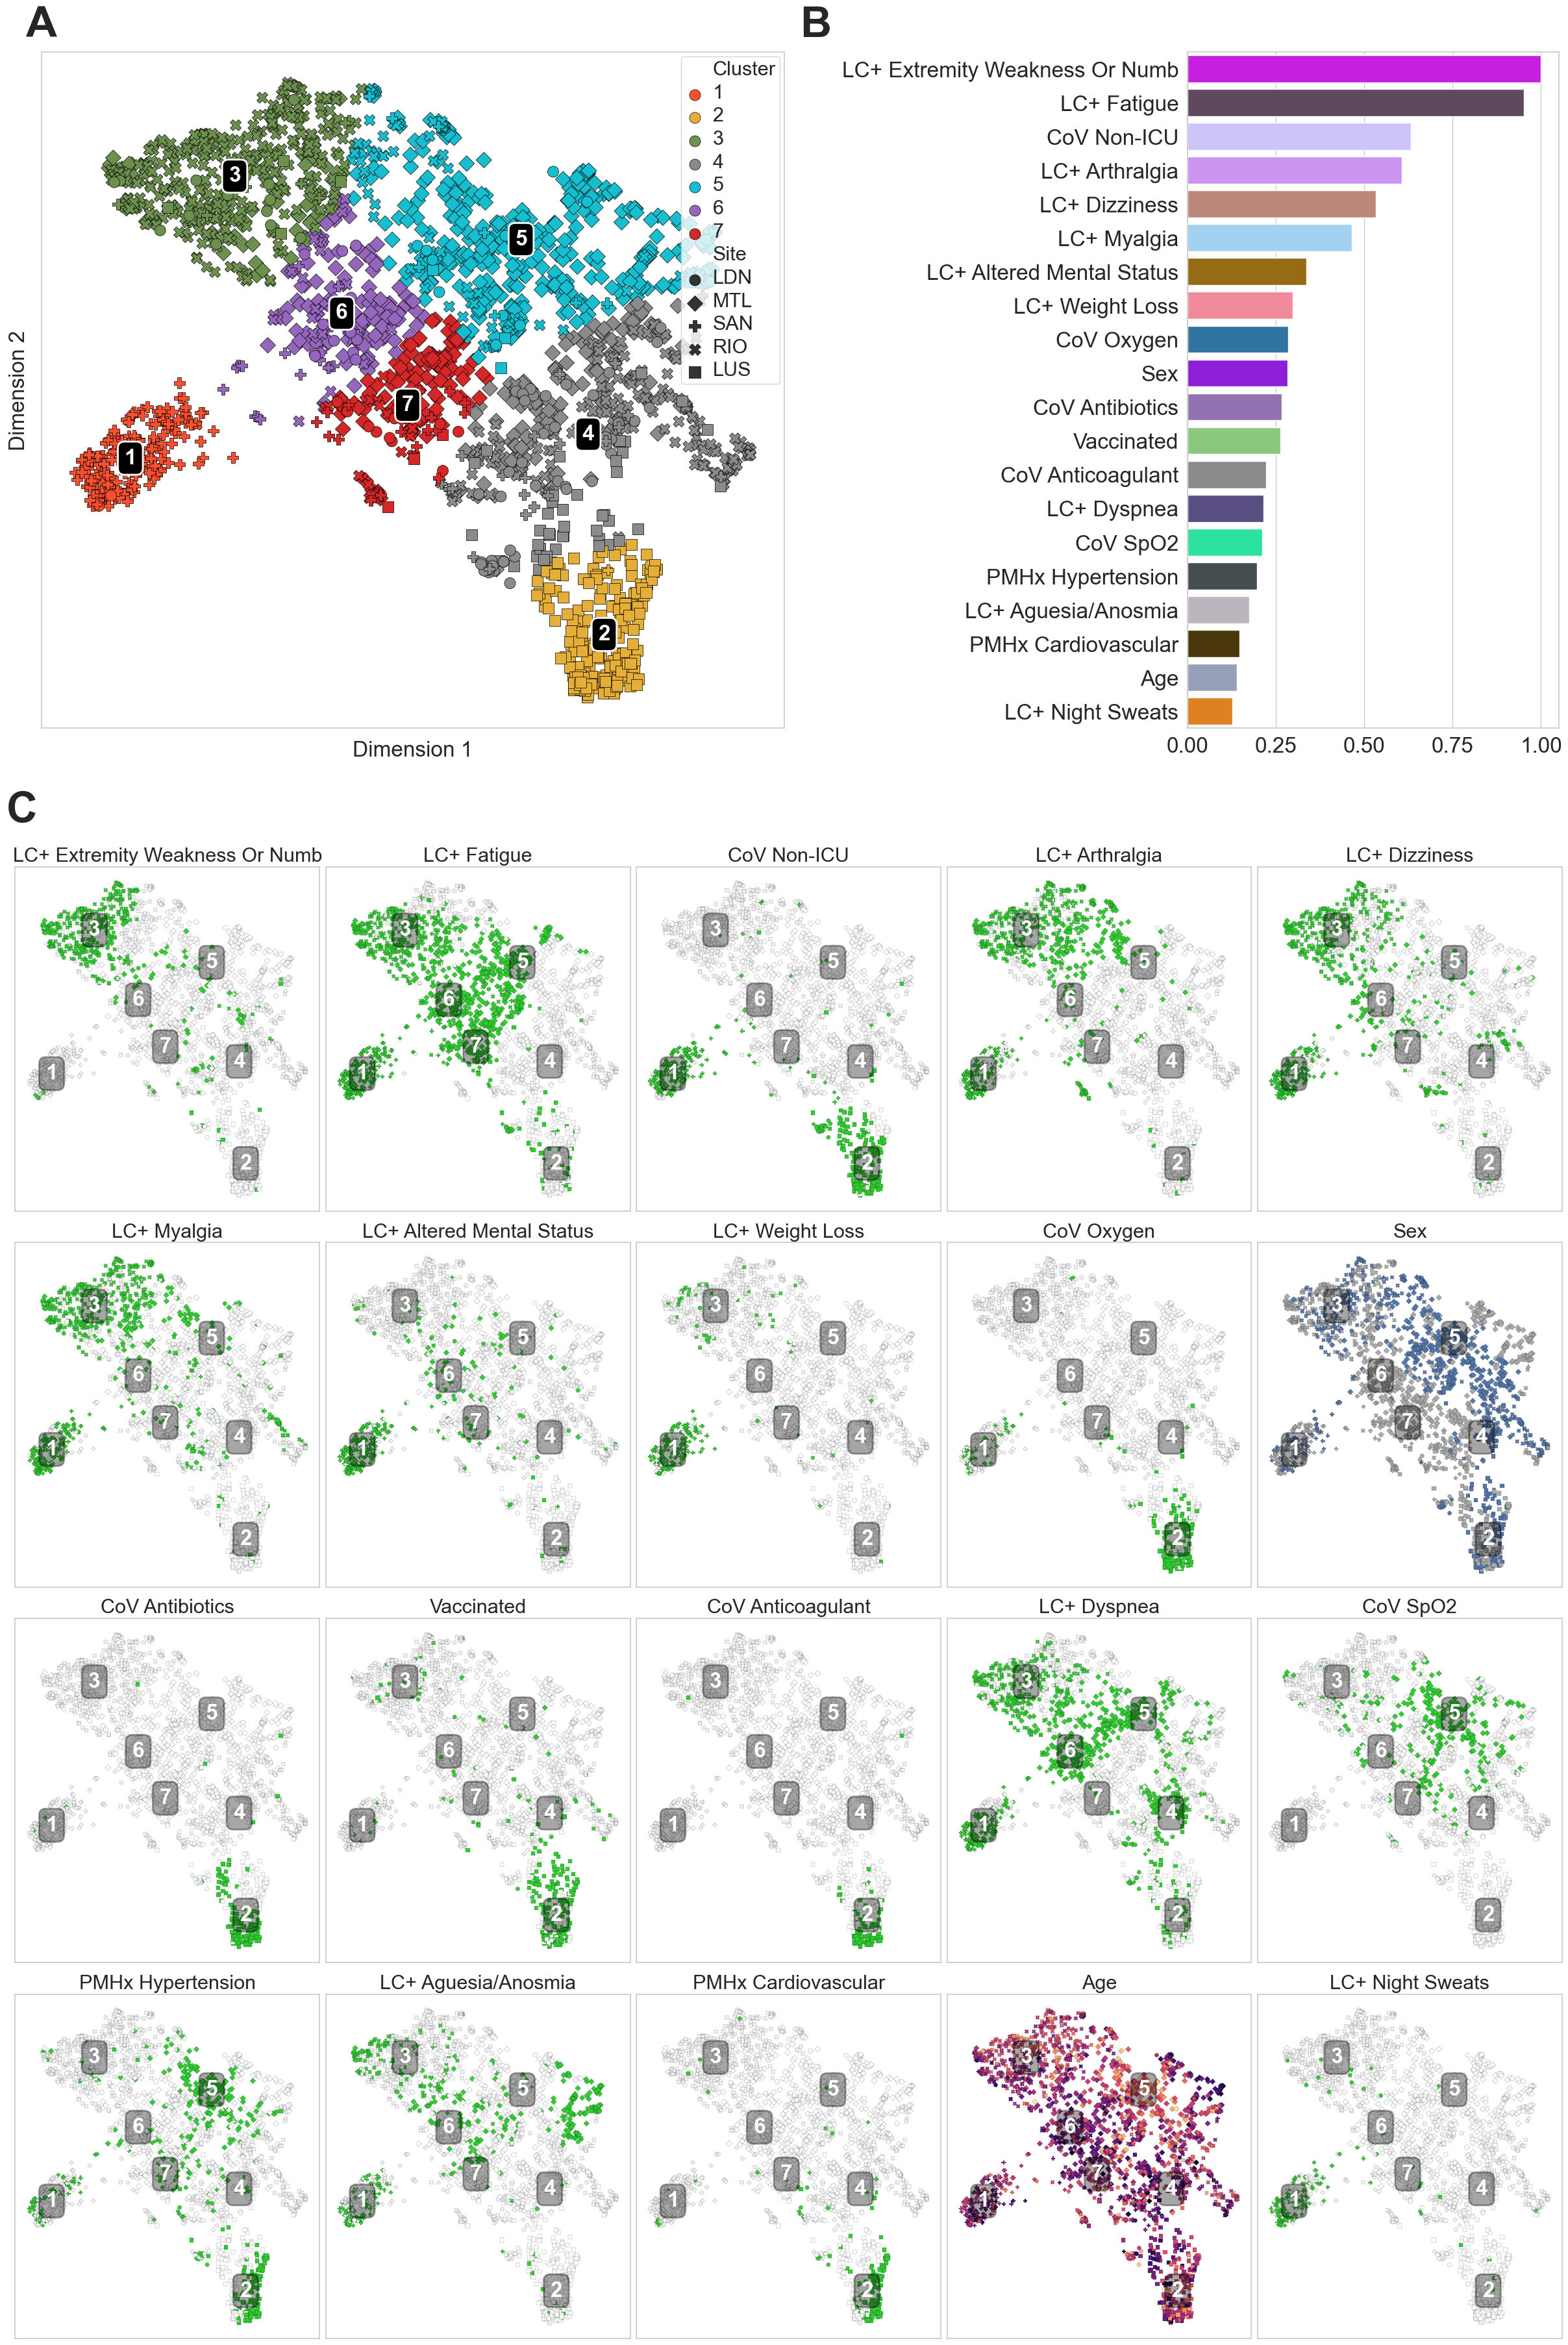

In [40]:
fig = plt.figure(layout="constrained", figsize=(24,36))
subfigs = fig.subfigures(2, 1, wspace=0.05, height_ratios=[2,4], hspace = 0.05)

axs0 = subfigs[0].subplots(1, 2, width_ratios=[2,1])
# subfigs[0].set_facecolor('lightblue')

plot_clusters(plot_df, site_name_dict, title = None, centroids = True, size_by_prob = False, ax = axs0[0])
# add annotation abve the plot
axs0[0].annotate("A",
                    xy=(0.0, 1.01), 
                    xycoords='axes fraction',
                    xytext=(0.0,0.0), 
                    textcoords = 'offset points',
                    fontsize = FONTSIZE*2,
                    horizontalalignment='center', 
                    verticalalignment='bottom',
                    fontweight = "bold",
                    )


# plot_clusters(plot_df, site_name_dict, title = None, centroids = True, size_by_prob = False, ax = axs0[1])

plot_feature_importances(features20, feature_map, feature_colour_map, axs0[1], FONTSIZE)


axs0[1].annotate("B",
                    xy=(-1.0, 1.01), 
                    xycoords='axes fraction',
                    xytext=(0.0,0.0), 
                    textcoords = 'offset points',
                    fontsize = FONTSIZE*2,
                    horizontalalignment='center', 
                    verticalalignment='bottom',
                    fontweight = "bold",
                    )


# make an array of axes for the second subfigure
axs1 = subfigs[1].subplots(4,5)

plot_multiple_features(dd, 
                        X,
                        plot_df, 
                        feature_map, 
                        highlight_colour = "limegreen",
                        ax = axs1,
                        subfig_label = " ",
                        )

# subfigs[1].suptitle(" ")
subfigs[1].suptitle('C', fontsize=FONTSIZE*2, fontweight='bold', x = 0.0, y = 1.02, ha='left', va='top')
# plt.show()

plt.savefig(f"{figdir}/feature-importances.png", dpi = 600, bbox_inches = 'tight')
plt.savefig(f"{figdir}/feature-importances.pdf",  bbox_inches = 'tight')

### Excursion Plots

In [41]:
# make a table of features and their importances from the classifier
fi_df = pd.DataFrame(clf.feature_importances_, 
                     index = clf.feature_names_in_, 
                     columns = ["Importance"])

# make a table of all of the features and their rankings
fff = pd.DataFrame({
                        "Feature": X.columns, 
                        "Ranking": boruta.ranking_, 
                        "Importance":boruta.support_, })


# fill fff with the feature importances
# start with zero
fff["FI"] = 0.0

# now fill in the numeric values for the important features
for i, f in fff.iterrows():
    if f["Importance"] == True:
        # print(i,f["Feature"], fi_df.loc[f["Feature"]]["Importance"])
        fff.loc[i, "FI"] = fi_df.loc[f["Feature"]]["Importance"]

# sort by FI
fff.sort_values(by = "FI", ascending = False, inplace = True)

In [42]:
# save the cluster labels to a copy of the original dataframe
A = X.copy()
M = X.copy()

# sosrt columns in the order set in fff
M = M[fff["Feature"]]

# augment with cluster labels
A["cluster"] = [c+1 for c in cluster_labels]
M["cluster"] = [c+1 for c in cluster_labels]


In [54]:
cluster_by_site

Cluster      1      2      3      4      5      6      7
Site                                                    
LDN        2.0    1.0   14.0   53.0   12.0   17.0   11.0
LUS        0.0  213.0    4.0   44.0    4.0    0.0    3.0
MTL        0.0    0.0   75.0  164.0  399.0  130.0  127.0
RIO        1.0    0.0  335.0  182.0   79.0   26.0   27.0
SAN      191.0    1.0    8.0   22.0    9.0   16.0   19.0

In [56]:
cluster_by_site.T

Site      LDN    LUS    MTL    RIO    SAN
Cluster                                  
1         2.0    0.0    0.0    1.0  191.0
2         1.0  213.0    0.0    0.0    1.0
3        14.0    4.0   75.0  335.0    8.0
4        53.0   44.0  164.0  182.0   22.0
5        12.0    4.0  399.0   79.0    9.0
6        17.0    0.0  130.0   26.0   16.0
7        11.0    3.0  127.0   27.0   19.0

In [59]:
cbsm = cluster_by_site.T/cluster_by_site.sum(axis = 1)*100

# rename the index column
cbsm.index.name = "cluster"

# map the site_fullname_dict to the index
cbsm.columns = cbsm.columns.map(site_fullname_dict)
cbsm = cbsm.T
cbsm

cluster                 1          2          3          4          5  \
Site                                                                    
London           1.818182   0.909091  12.727273  48.181818  10.909091   
Lusaka           0.000000  79.477612   1.492537  16.417910   1.492537   
Montreal         0.000000   0.000000   8.379888  18.324022  44.581006   
Rio de Janeiro   0.153846   0.000000  51.538462  28.000000  12.153846   
San Diego       71.804511   0.375940   3.007519   8.270677   3.383459   

cluster                 6          7  
Site                                  
London          15.454545  10.000000  
Lusaka           0.000000   1.119403  
Montreal        14.525140  14.189944  
Rio de Janeiro   4.000000   4.153846  
San Diego        6.015038   7.142857

In [60]:
zzz = M.groupby("cluster").mean()



# get the first 20 columns
zzz = zzz[fff["Feature"][:20]]

# rename the columns
for c in zzz.columns:
    zzz.rename(columns = {c: feature_map[c]}, inplace = True)


# drop age and sex
zzz = zzz.drop(columns = ["Age", "Sex"])


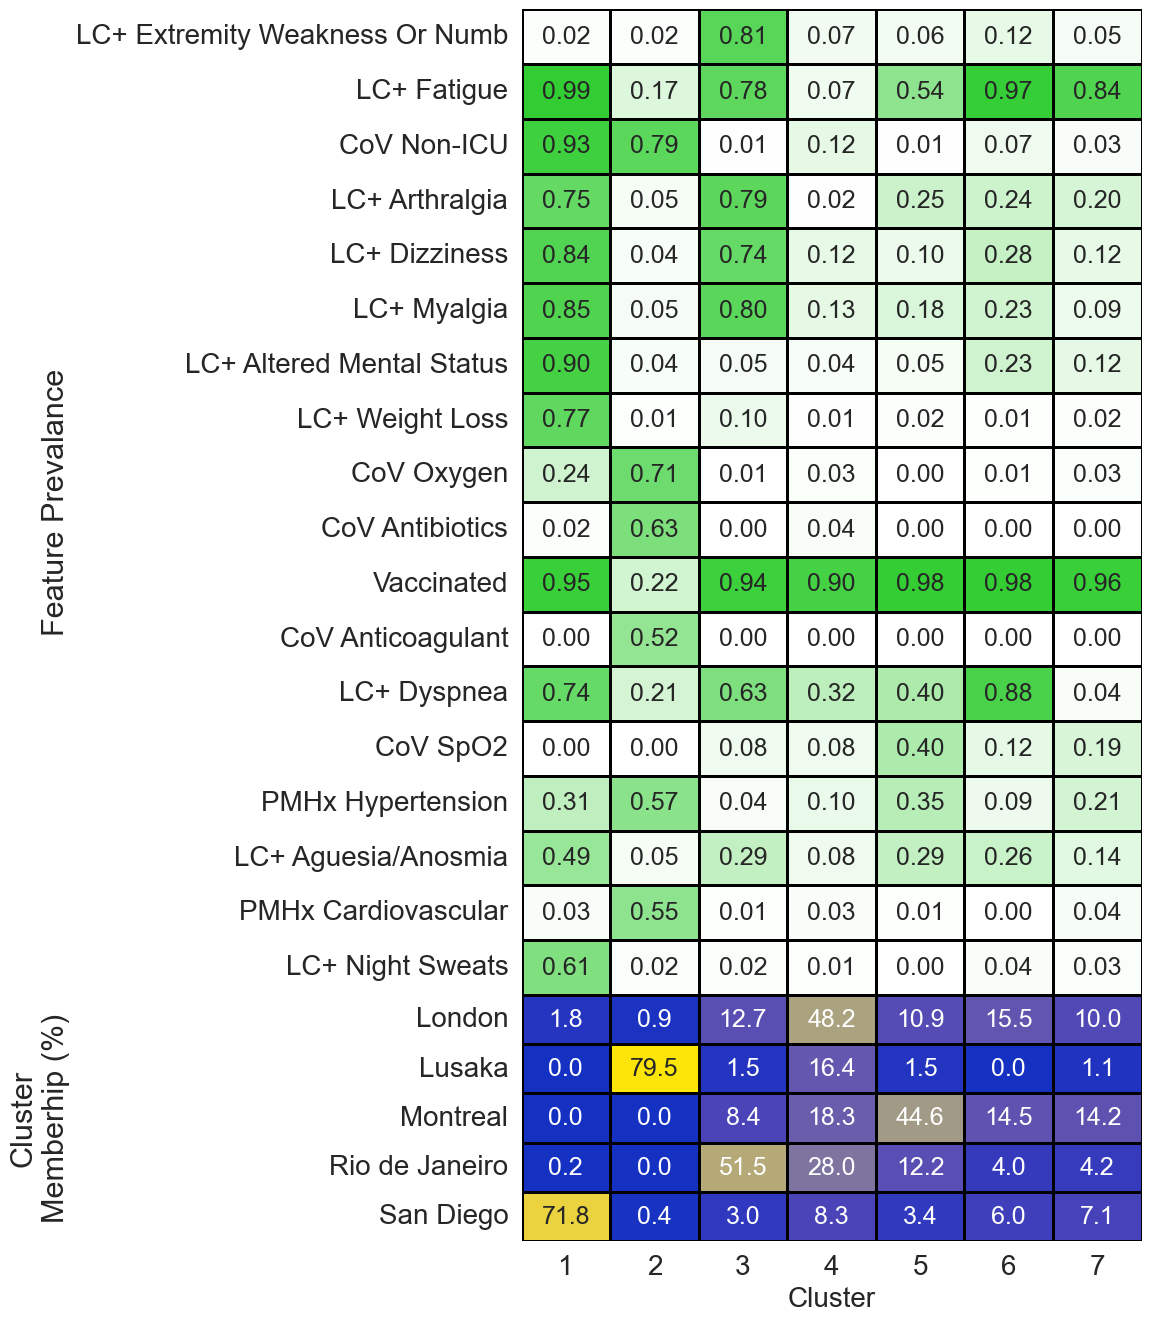

In [61]:


fig, (axs0, axs1) = plt.subplots(2, 1, figsize=(8,16),  sharex = True, height_ratios=[8,2])
fig.subplots_adjust(hspace = 0.0)

sns.heatmap(zzz.T, 
            cmap = cmap, 
            ax = axs0, 
            cbar = False, 
            vmin = 0, 
            linewidth = 1, 
            # linewidth = 0.5, 
            square = False, 
            linecolor = 'k',
              annot = True,
                fmt = ".2f",
                annot_kws = {"fontsize": 18}
)

# turn off the xticks and x label
axs0.set_xticks([]); axs0.set_xlabel("")

sns.heatmap(cbsm,
            # cmap = 'viridis', 
            cmap = cc.cm.bjy, 
            ax = axs1, 
            cbar = False, 
            vmin = 0, 
            linewidth = 1, 
            # linewidth = 0.5, 
            square = False, 
            linecolor = 'k',
              annot = True,
                fmt = ".1f",
                annot_kws = {"fontsize": 18}
)
axs0.set_ylabel("Feature Prevalance", fontsize = FONTSIZE-2)
axs1.set_ylabel("Cluster\nMemberhip (%)", fontsize = FONTSIZE-2)
# rotate axs1 yticks 90 degrees
axs1.set_yticklabels(axs1.get_yticklabels(), rotation = 00)

# make x axis label alrger
axs1.set_xlabel("Cluster", fontsize = FONTSIZE-4)
#make tick labels larger
axs1.tick_params(axis='both', which='major', labelsize=FONTSIZE-4)
axs0.tick_params(axis='both', which='major', labelsize=FONTSIZE-4)

# fig.align_xlabels()

# align the ylabels
fig.align_ylabels()

# output the figure
plt.savefig(f"{figdir}/feature-prevalence-by-cluster.png", dpi = 600, bbox_inches = 'tight')


### UPSET PLOTS

In [ ]:
A["SITE"] = LC_pos_["SITE"]

In [ ]:
II = pd.DataFrame(scaler.inverse_transform(A.drop(["cluster", "SITE"], axis = 1))) # type: ignore

# get column names and index names from X 
II.columns = X.columns
II.index   = X.index

In [ ]:
# A.shape, X.shape, II.shape
# vv = A.drop("cluster", axis = 1)
B = II.copy()

# augment with site labels
B["SITE"] = LC_pos_["SITE"].map(site_name_dict)

# expand the SITE column to five one-hot encoded columns
# B = pd.concat([B, pd.get_dummies(B["SITE"])], axis = 1)

In [ ]:
# interesting = list(g.index[:5])

In [ ]:
interesting = list(fff["Feature"][:5])

In [ ]:
upset_A = make_upset_data(A, 
                       interesting, 
                       )

upset_data = make_upset_data(B, 
                                interesting, 
                                keep_features = True
                                )

indicators_bool = upset_data.select_dtypes(include = ['bool'])

/Users/david/mambaforge/envs/clust/lib/python3.11/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/Users/david/mambaforge/envs/clust/lib/python3.11/site-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are settin

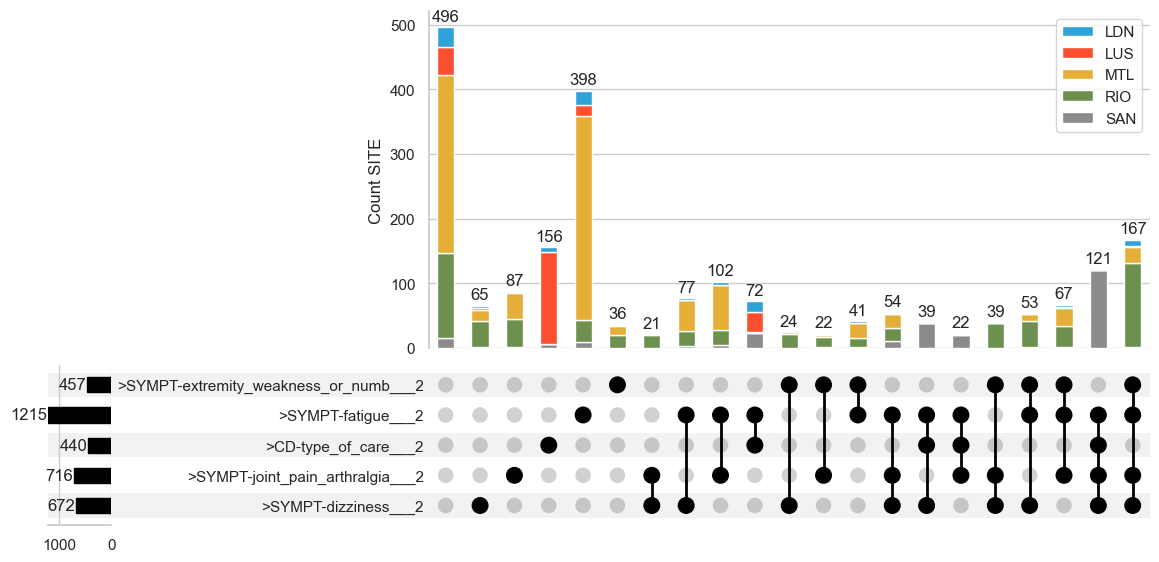

In [ ]:
us = UpSet(
    from_indicators(indicators_bool, data = upset_data),
    min_subset_size=15,
    # max_subset_size=200,
    show_counts                = True,
    sort_categories_by         = "-input",
    subset_size                = "count",
    intersection_plot_elements = 0,
    orientation                = "horizontal",
)

# us.style_subsets(present = ">HHX-HIV or AIDS",  edgecolor = cc.glasbey_light[0],  linewidth = 3, )

us.add_stacked_bars(by="SITE", 
                       title="Count SITE", 
                       elements=10, 
                       colors = cc.m_glasbey_hv, 
                       )

us.plot()
plt.show()

In [ ]:
# upset = UpSet(upset_A, 
#                 subset_size = "count", 
#                 orientation = "horizontal", 
#                 sort_categories_by         = "-input",
#                 show_counts = False, 
#                 intersection_plot_elements = 0,
#                 max_subset_size = 200
#                 )
# # upset.style_subsets(present = ">HHX-HIV or AIDS",  edgecolor = "red", linewidth = 3)
# # upset.style_categories(">HHX-HIV or AIDS", shading_facecolor = "blue")

# # upset.add_stacked_bars(by="cluster", title="Count Cluster", elements=5, colors = cc.m_glasbey_hv)


# upset.plot()
# plt.show()

# SUBGROUPS

In [ ]:
# subgroup_site = 5



# # make a df just for Lusaka
# subgroup_df = LC_pos_.query(f'SITE == {subgroup_site}').copy()


# # drop object columns
# # drop columns with dtype = object
# try:
#     subgroup_df = subgroup_df.drop(columns=['LC_STATUS'])

# except:
#     pass

# # fill nas with zero
# # df_lusaka.fillna(0, inplace = True)
# subgroup_df.dropna(inplace = True, axis = 1)
# print(subgroup_df.shape)

# # drop SITE
# d1 = subgroup_df.drop(columns = ['SITE'])


# # sklearn pipelines
# import sklearn.cluster as cluster
# from sklearn.pipeline import Pipeline

# # instantiate the pipeline
# hdb_parms['min_cluster_size'] = int(np.sqrt(d1.shape[0]))

# pipe = Pipeline([
#                 ('scale', MinMaxScaler()),
#                 ('embed', UMAP(verbose = True)),
#                 # ('embed', tsne_transformer),
#                 # ('cluster', cluster.HDBSCAN(min_cluster_size = min_cluster_size)),
#                 ('cluster', HDBSCAN(**hdb_parms, prediction_data = True)),

#                 ])

# # apply to the lusaka dataframe
# pipe.fit(d1)

# # check the version of the embed object

# if isinstance(pipe.steps[1][1], UMAP):
#     points   = pipe["embed"].embedding_
# elif isinstance(pipe.steps[1][1], FunctionTransformer):
#     points   = pipe["embed"].transform(d1)
# else:
#     print(f"Something went wrong - {pipe.steps[1][1]}")

# clusters = pipe["cluster"].labels_
# probs    = pipe["cluster"].probabilities_
# sites    = LC_pos_.loc[X.index]["SITE"].map(site_name_dict)

# # # cluster labels are the maximally probable cluster
# cluster_labels = np.argmax(all_points_membership_vectors(pipe["cluster"]), 
#                            axis = 1)

# clusters = cluster_labels

# # plot it
# # sns.scatterplot(x = points[:,0], y = points[:,1], hue = clusters, palette = palette_dict, size = list(probs*100), linewidth = 0.5, edgecolor = 'black')
# d1.shape, subgroup_df.shape
# len(points)
# plot_df = pd.DataFrame(points, columns = ["x", "y"], index = subgroup_df.index)
# plot_df["Cluster"] = clusters
# plot_df["Cluster Confidence"] = probs
# plot_df["Site"] = subgroup_df["SITE"].map(site_name_dict)

# # what fraction of the data is in each cluster?
# plot_df["Cluster"].value_counts(normalize = True)*100

# plot_clusters(plot_df, site_name_dict, title = f"UMAP + HDBSCAN Clustering - {site_name_dict[subgroup_site]}", centroids = True, size_by_prob = True, ax = None)
# # use a random forest classifier to find the most important features
# from sklearn.ensemble import RandomForestClassifier

# # instantiate the classifier
# rf = RandomForestClassifier(n_estimators = 1_000, max_depth = 5, random_state = 42)



# X = subgroup_df

# # fit the classifier

# rf.fit(X, cluster_labels)
# # get the 10 most important features
# importances = rf.feature_importances_

# indices = np.argsort(importances)[::-1][:10]

# # get the feature names
# # features = X.columns.map(feature_map)
# features = X.columns

# for f in X.columns:
#     try:
#         print(f, feature_map[f])
#     except:
#         pass

# # plot the feature importances
# plt.figure(figsize=(10, 6))

# plt.title("Feature importances")

# sns.barplot(x = importances[indices], y = features[indices], palette = "viridis", hue = features[indices])

(272, 245)


In [ ]:
# subgroup_features = pd.DataFrame(importances[indices], 
#                                  index = features[indices], 
#                                  columns = ["Importance"])

# # convert the index to a column
# subgroup_features.reset_index(inplace = True)

# # rename the columns
# subgroup_features.rename(columns = {"index": "Feature"}, inplace = True)
# subgroup_features

Feature  Importance
0  CD-medication_received___5    0.132173
1  CD-medication_received___1    0.128587
2  CD-medication_received___3    0.107582
3   MED-Cardiovascular-agents    0.073880
4   HHX-Arterial Hypertension    0.067647
5  CD-medication_received___4    0.064673
6          CD-required_oxygen    0.047793
7         CD-type_of_care___2    0.047196
8                HHX-Diabetes    0.024845
9                         sex    0.024277

0 CD-medication_received___5
CD-medication_received___5
Present    157
Absent     115
Name: count, dtype: int64
1 CD-medication_received___1
CD-medication_received___1
Absent     165
Present    107
Name: count, dtype: int64
2 CD-medication_received___3
CD-medication_received___3
Absent     157
Present    115
Name: count, dtype: int64
3 MED-Cardiovascular-agents
MED-Cardiovascular-agents
Absent     144
Present    128
Name: count, dtype: int64
4 HHX-Arterial Hypertension
HHX-Arterial Hypertension
Absent     140
Present    132
Name: count, dtype: int64
5 CD-medication_received___4
CD-medication_received___4
Absent     165
Present    107
Name: count, dtype: int64
6 CD-required_oxygen
CD-required_oxygen
Present    161
Absent     111
Name: count, dtype: int64
7 CD-type_of_care___2
CD-type_of_care___2
Present    200
Absent      72
Name: count, dtype: int64
8 HHX-Diabetes
HHX-Diabetes
Absent     223
Present     49
Name: count, dtype: int64
9 sex
sex
Present    124
Name: count, dtype: int64


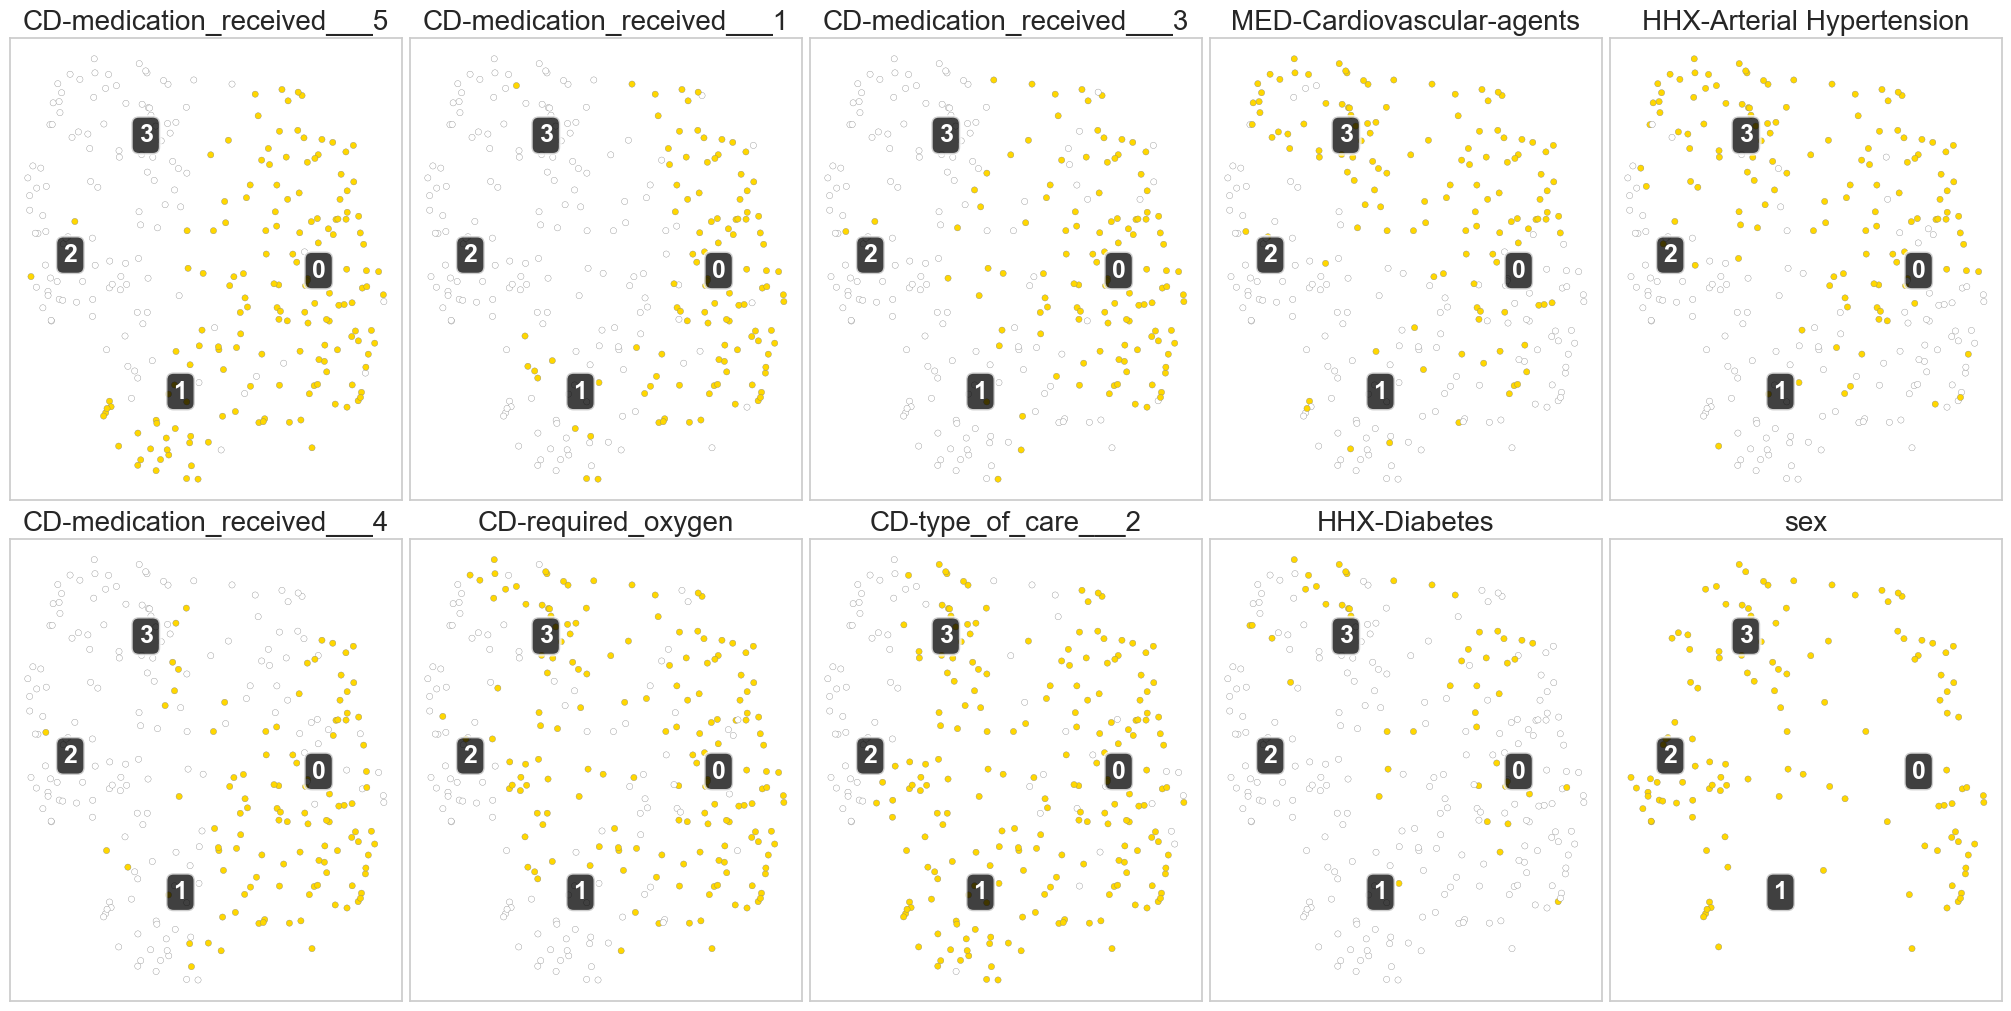

In [ ]:


# # multiplots
# sympt_dict = {0:"Absent", 1:"Present"}
# # int_feat = dd["Feature"][:20]
# # int_feat = features20["Feature"]

# int_feat = subgroup_features["Feature"]

# centroids = make_centroids(plot_df[["x", "y"]].values, plot_df["Cluster"])

# fig, ax = plt.subplots(2, 5, figsize=(20, 10), sharex = True, sharey = True, layout = "constrained")

# ax  = ax.flatten()

# # plot the features by cluster
# for i, f in enumerate(int_feat):

#     print(i,f)

#     the_ax = ax[i]

#     plot_df[f] = X[f].map(sympt_dict)
#     palette = ['white', '#787878']
#     palette = ['white', 'gold']
#     hue_order = ["Absent", "Present"]

#     print(plot_df[f].value_counts())

#     sns.scatterplot(data = plot_df, 
#                     x         = "x", 
#                     y         = "y", 
#                     hue       = f,
#                     palette   = palette, 
#                     hue_order = hue_order,
#                     # style     = "Site", 
#                     # style_order = site_name_dict.values(), 
#                     markers   = ['s'], 
#                     edgecolor = 'gray', 
#                     linewidth = 0.25, 
#                     s         = 20, 
#                     ax        = the_ax
#                     )

#     plot_centroids(centroids, the_ax, alpha = 0.75, fontsize = 18)

#     # turn off the ticks on the ax
#     the_ax.set_xticks([]); the_ax.set_yticks([])
#     the_ax.set_xlabel(""); the_ax.set_ylabel("")

#     # set axis title
#     the_ax.set_title(subgroup_features["Feature"][i], fontsize = FONTSIZE-4)

#     # set title size smaller
#     # the_ax.title.set_size(FONTSIZE)

#     # turn off the legnd on the ax
#     the_ax.legend().remove()



/Users/david/mambaforge/envs/clust/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


<Axes: >

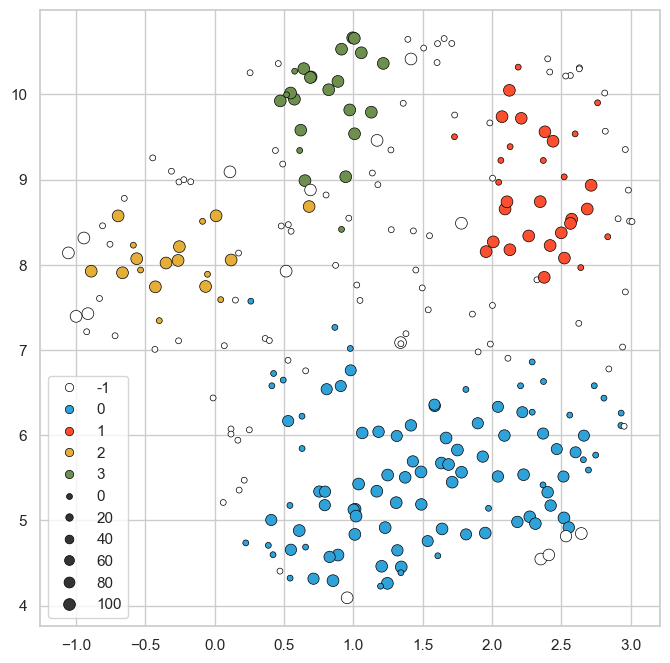

In [ ]:
# # use the cluseter labels to guide umap


# d2 = scaler.fit_transform(d1)

# min_cluster_size = int(np.sqrt(d2.shape[0]))

# # d2 = d1

# hdb_l = HDBSCAN(min_cluster_size = min_cluster_size, min_samples = min_cluster_size, cluster_selection_method = 'leaf', cluster_selection_epsilon = 0.1)
# umap_l = UMAP(n_neighbors = 15, min_dist = 0.1, n_components = 2, random_state = 42)

# embeddings = umap_l.fit_transform(d2)
# clusters   = hdb_l.fit_predict(embeddings)
# sns.scatterplot(x = embeddings[:,0], 
#                 y = embeddings[:,1], 
#                 hue = clusters, 
#                 palette = palette_dict, 
#                 size = list(probs*100), 
#                 linewidth = 0.5, 
#                 edgecolor = 'black')